In [33]:
import sqlite3

database = sqlite3.connect(r"C:\\Users\\swavi\\Documents\\GitHub\\F1-Stop-Strategy\\Databases\\database.db")
cursor = database.cursor()
driverIds = []
year = 2025

cursor.execute(
		"""SELECT raceID FROM Race WHERE year = ?""",
				(year,)
					)
races = [r[0] for r in cursor.fetchall()]


def getDrivers(raceId):
		cursor.execute(
			"""
			SELECT DISTINCT d.driverId, d.code
			FROM Driver d
			JOIN LAP l ON l.driverId = d.driverId
			WHERE l.raceId = ?
			""",
			(raceId,)
		)
		drivers = cursor.fetchall()
		return drivers


In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from sklearn.cluster import HDBSCAN
import matplotlib.pyplot as plt
import numpy as np
plt.ioff()
scaler = StandardScaler()


allLaps = []
allDrivers = []

columns = [
    "throttlePerc100",
    "throttlePerc0",
    "avCornerBrakeDistance",
    "throttleOscillation",
    "coastingPerc",]


data = {col: [] for col in columns}

In [7]:
def collectingData(race, driverIds, driverCodes, averages):
  rows = []
  
  for driverId, driverCode in zip(driverIds, driverCodes):
    cursor.execute(
      """SELECT lapId
         FROM Lap 
         WHERE raceId = ? AND driverId = ? AND attacking = ? AND defending = ?""",
      (race, driverId, 0, 0)
    )
    
    lapIds = [laps[0] for laps in cursor.fetchall()]
    lapFeatures = []
    
    for lapId in lapIds:
      cursor.execute(
        f"""SELECT {",".join(columns)}
            FROM Features
            WHERE lapId = ?""",
        (lapId,)
      )
      
      row = cursor.fetchone()
      
      if row is None:
        continue
      if any(feature is None for feature in row):
        continue
      
      lapFeatures.append(row)
    
    lapFeatures = np.array(lapFeatures, dtype=float)
    
    if averages:
      values = lapFeatures.mean(axis=0)
      rows.append(
        dict(zip(columns, values), driver=driverCode, raceId=race)
      )
    else:
      for row in lapFeatures:
        rows.append(
          dict(zip(columns, row), driver=driverCode, raceId=race)
        )
  
  return pd.DataFrame(rows)


In [8]:
averages = len(races) > 1
rows = []

for race in races:
		drivers = getDrivers(race)
		driverIds = [row[0] for row in drivers]
		driverCodes = [row[1] for row in drivers]
		dfRace = (collectingData(race,driverIds,driverCodes,averages))
		rows.append(dfRace)

df = pd.concat(rows, ignore_index=True)

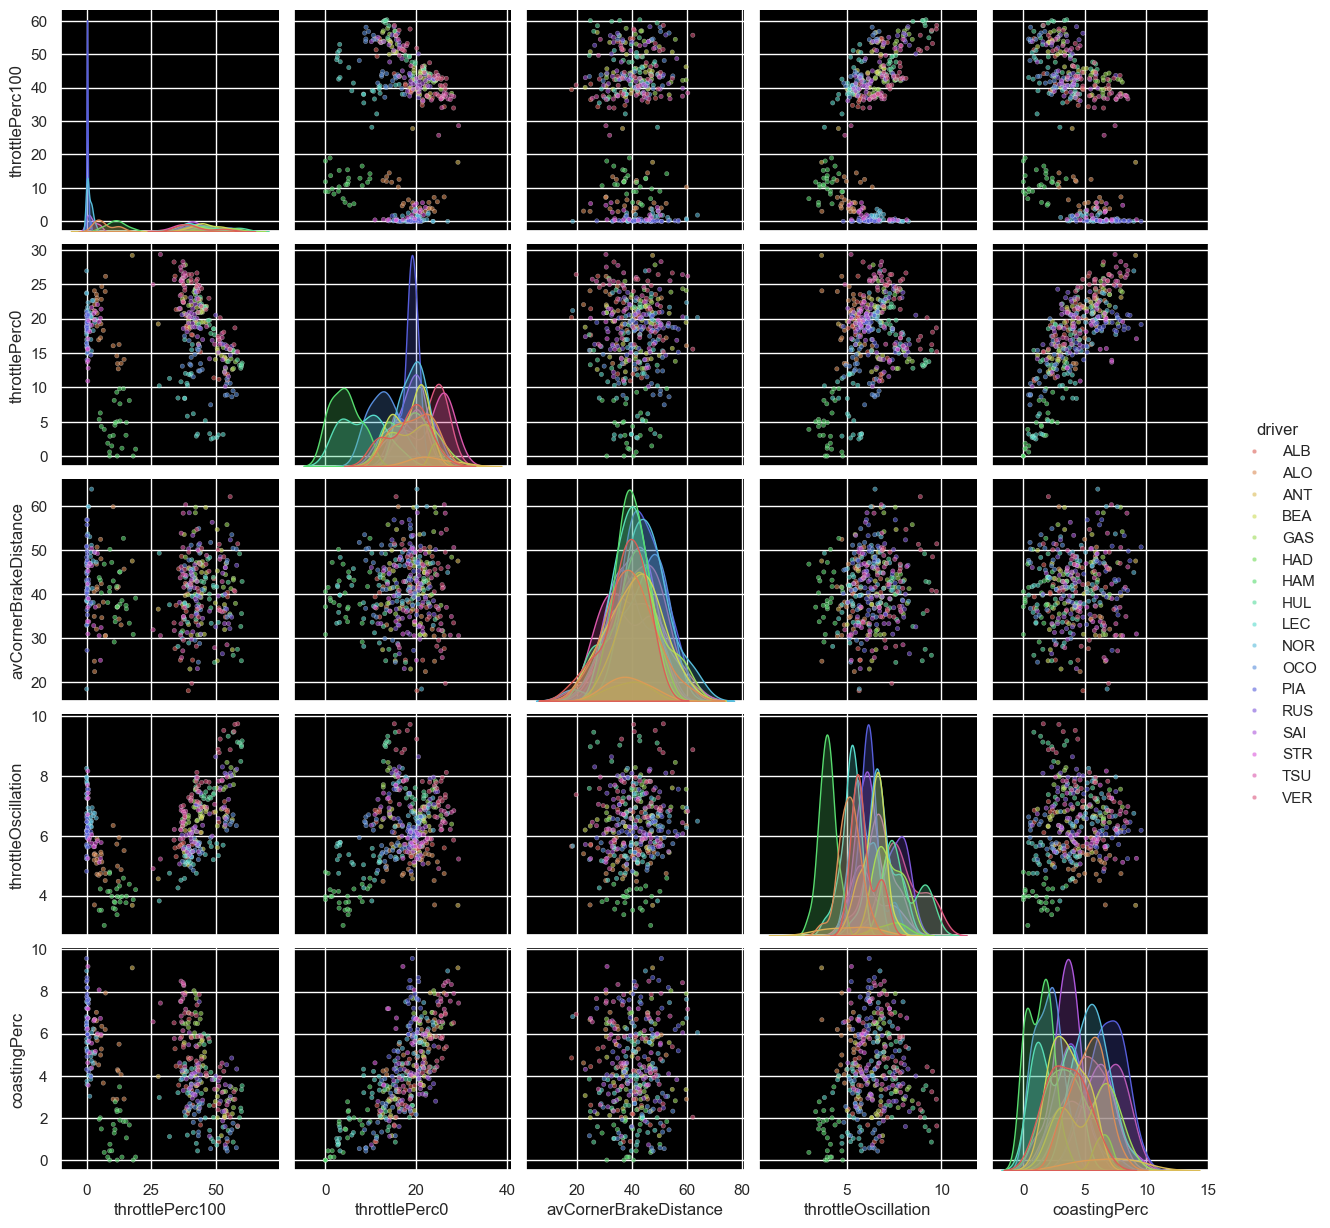

In [10]:
palette = sns.color_palette("hls", len(driverCodes))
driverColours = {driverCodes[i]: palette[i] for i in range(len(driverCodes))}


sns.set(rc={'axes.facecolor': 'black', 'figure.facecolor': 'white'})

sns.pairplot(
    df,
    vars=columns,
    hue="driver",
    palette=driverColours,
    plot_kws={"s": 10, "alpha": 0.6}
)
plt.show()

In [31]:
from hdbscan import HDBSCAN

features = columns  
allLapsDF = df[features].copy()
scaler = StandardScaler()
scaled = scaler.fit_transform(allLapsDF)
pca = PCA(n_components=0.95)
Xpca = pca.fit_transform(scaled)
hdb = HDBSCAN(min_cluster_size=10, min_samples=2,
                      cluster_selection_method='leaf', metric='euclidean',prediction_data=True)
labels = hdb.fit_predict(Xpca)
df = df.reset_index(drop=True) 
df["cluster"] = labels
clusterSummary = df.groupby("cluster")[features].mean()
clusterAssignment = pd.crosstab(df.driver, df.cluster)
clusterAssignmentPercentage = (clusterAssignment.div(clusterAssignment.sum(axis=0),axis=1) *100).round(2)
print(clusterAssignment)

cluster  -1   0   1   2   3   4   5   6   7   8   9
driver                                             
ALB      12   0   0   0   0   2   0   2   0   5   3
ALO      18   0   4   2   0   0   0   0   0   0   0
ANT       3   0   0   0   1   0   0   0   0   0   0
BEA      15   0   0   0   1   2   1   3   0   1   3
GAS      10   0   0   0   2   0   0   3   6   0   0
HAD       2   0   0   0   1   0   0   0   0   0   0
HAM      13  13   0   0   0   0   0   0   0   0   0
HUL      11   0   0   0   0   0   0   7   4   0   0
LEC      21   0   0   0   0   0   3   0   0   2   0
NOR      20   0   0  10   0   0   0   0   0   0   0
OCO      13   0   0   0   0   5   7   0   0   1   0
PIA      14   0   2  14   0   0   0   0   0   0   0
RUS      12   0   0   0   0   0   0   4   3   0   1
SAI      16   0   0   0   0   2   0   0   0   3   7
STR       9   0   4   5   0   0   0   0   0   0   0
TSU      19   0   0   0   4   0   0   0   3   0   0
VER      22   0   0   0   2   0   0   3   0   0   0


C:\Users\swavi\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\swavi\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


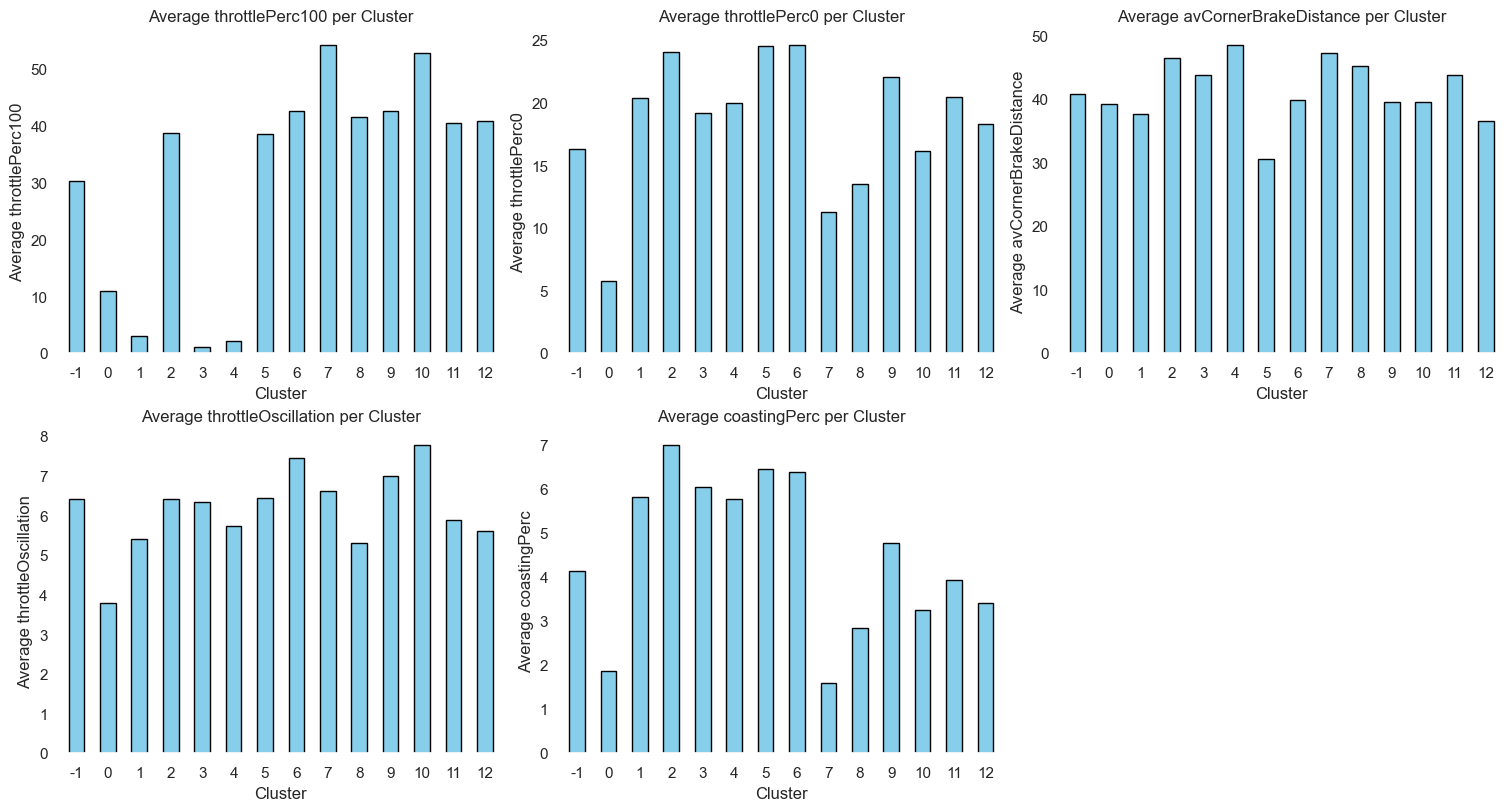

In [18]:
columns = clusterSummary.columns
nColumns = len(columns)
nRows = int(np.ceil(nColumns/3))
fig, axes = plt.subplots(nRows, 3, figsize=(
    15, 4*nRows), constrained_layout=True, facecolor='white')
if nRows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for index, col in enumerate(columns):
    ax = axes[index]
    clusterSummary[col].plot(
        kind='bar', color='skyblue', edgecolor='black', ax=ax)
    ax.set_title(f'Average {col} per Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(f'Average {col}')
    ax.set_facecolor('white')
    ax.tick_params(rotation=0)

for index in range(len(columns), len(axes)):
    axes[index].set_visible(False)
plt.show()

In [32]:
from hdbscan import approximate_predict

testingLap = pd.DataFrame([{
    "throttlePerc100": 90,
    "throttlePerc0": 5,
    "avCornerBrakeDistance": 30,
    "throttleOscillation": 2.5,
    "coastingPerc": 15
}])

scaledTestLap = scaler.transform(testingLap[columns])
pcaTestLap = pca.transform(scaledTestLap)
clusterLabel, clusterProb = approximate_predict(hdb,pcaTestLap)
print("Predicted cluster:",clusterLabel[0])
print("Membership probability:",clusterProb[0])

likelyDrivers = clusterAssignmentPercentage[clusterLabel[0]].sort_values(ascending = False)
print("Most likely drivers for this lap: ",likelyDrivers)



Predicted cluster: -1
Membership probability: 0.0
Most likely drivers for this lap:  driver
VER    9.57
LEC    9.13
NOR    8.70
TSU    8.26
ALO    7.83
SAI    6.96
BEA    6.52
PIA    6.09
HAM    5.65
OCO    5.65
ALB    5.22
RUS    5.22
HUL    4.78
GAS    4.35
STR    3.91
ANT    1.30
HAD    0.87
Name: -1, dtype: float64


In [28]:
df['PC1'] = Xpca[:, 0]
df['PC2'] = Xpca[:, 1]

plt.figure(figsize=(12, 8))
palette = sns.color_palette("hls", len(drivers))
driverColors = {driver: palette[i] for i, driver in enumerate(drivers)}

sns.scatterplot(
    x='PC1', y='PC2',
    hue='driver',
    data=df,
    palette=driverColors,
    alpha=0.7,
    s=50
)

plt.title("PCA Driving Style Map")
plt.gca().set_facecolor('black')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

ValueError: The palette dictionary is missing keys: {'ALO', 'LEC', 'BEA', 'HAD', 'ALB', 'HUL', 'RUS', 'TSU', 'ANT', 'VER', 'HAM', 'SAI', 'PIA', 'STR', 'NOR', 'GAS', 'OCO'}